In [15]:
# Shiyi (Amy) Qin and Victor Z
# UW-Madison, 2024
# ch6 use CNN for clasifying LC droplet data (case II)

## Start here if working on google collab

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Specify the path of this file (This may differ for each user!)
path = '/content/drive/MyDrive/StatsBookCode/Python/'

In [18]:
# This is to check if the speficied path above is correct
!echo $path
import os
os.path.isdir(path)

/content/drive/MyDrive/StatsBookCode/Python/


True

In [19]:
# This is needed so we can import packages from a different path than standard libraries
import sys
sys.path.append(path)

## Start from here if working on local computer

In [20]:
import numpy as np
from scipy.io import loadmat
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Fixing the random seeds for reproducibility
seed = 2024
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)

In [22]:
# Load IR data from .mat file
x = np.load(path+'Data/lc_img_sds_caseII.npy')
x = x/255. # convert to float and range between 0 and 1
x = np.transpose(x, (0, 3, 1, 2)) # reshape to have channels first to accomodate with dataloader
y = np.load(path+'Data/lc_label_sds_caseII.npy')
print(x.shape, y.shape)

(100, 3, 256, 256) (100,)


In [23]:
# Split the data into training and test sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed, shuffle=True)

In [24]:
print(x_train.shape, x_valid.shape)

(80, 3, 256, 256) (20, 3, 256, 256)


In [25]:
# Convert to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [26]:
# define CNN architecture

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256*256*1, 2)  # Assuming input image size is 50x50 and 2 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

In [27]:
model = SimpleCNN()

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:

# Training the model
num_epochs = 40
train_accuracy_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/40], Loss: 3.4174, Train Accuracy: 46.25%, Validation Accuracy: 65.00%
Epoch [2/40], Loss: 1.0402, Train Accuracy: 57.50%, Validation Accuracy: 50.00%
Epoch [3/40], Loss: 1.0508, Train Accuracy: 43.75%, Validation Accuracy: 60.00%
Epoch [4/40], Loss: 0.7722, Train Accuracy: 52.50%, Validation Accuracy: 70.00%
Epoch [5/40], Loss: 0.5081, Train Accuracy: 70.00%, Validation Accuracy: 65.00%
Epoch [6/40], Loss: 0.4463, Train Accuracy: 78.75%, Validation Accuracy: 85.00%
Epoch [7/40], Loss: 0.4289, Train Accuracy: 83.75%, Validation Accuracy: 80.00%
Epoch [8/40], Loss: 0.3897, Train Accuracy: 86.25%, Validation Accuracy: 85.00%
Epoch [9/40], Loss: 0.3858, Train Accuracy: 91.25%, Validation Accuracy: 65.00%
Epoch [10/40], Loss: 0.3341, Train Accuracy: 87.50%, Validation Accuracy: 65.00%
Epoch [11/40], Loss: 0.4578, Train Accuracy: 76.25%, Validation Accuracy: 85.00%
Epoch [12/40], Loss: 0.3614, Train Accuracy: 87.50%, Validation Accuracy: 70.00%
Epoch [13/40], Loss: 0.3069, Train Ac

In [30]:
# CNN prediction
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
conf_mat_train = confusion_matrix(all_labels, all_preds)

In [31]:
# CNN prediction
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
conf_mat_valid = confusion_matrix(all_labels, all_preds)

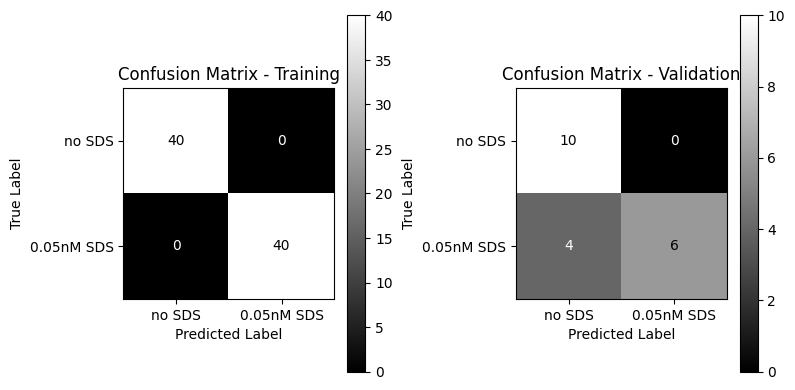

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

class_names = ['no SDS', '0.05nM SDS']

ConfusionMatrixDisplay(confusion_matrix=conf_mat_train, display_labels=class_names).plot(ax=ax[0], cmap='gray')
ax[0].set_title('Confusion Matrix - Training')
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

ConfusionMatrixDisplay(confusion_matrix=conf_mat_valid, display_labels=class_names).plot(ax=ax[1], cmap='gray')
ax[1].set_title('Confusion Matrix - Validation')
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

plt.tight_layout()
#plt.savefig(path+'Figures/ch6_lcdroplet_sds_confusion_caseII.eps', format='eps')
plt.show()

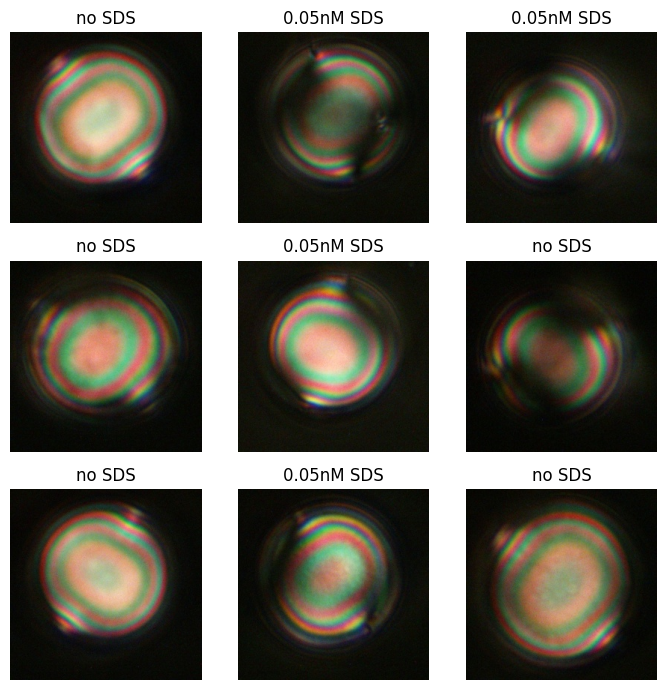

In [33]:
# Display some images from the validation set
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(7, 7))
val_iter = iter(valid_loader)
images, labels = next(val_iter)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(images[i], class_names[labels[i]])
plt.tight_layout()
#plt.savefig(path+'Figures/ch6_lcdroplet_sds_data_caseII.eps', format='eps')
plt.show()

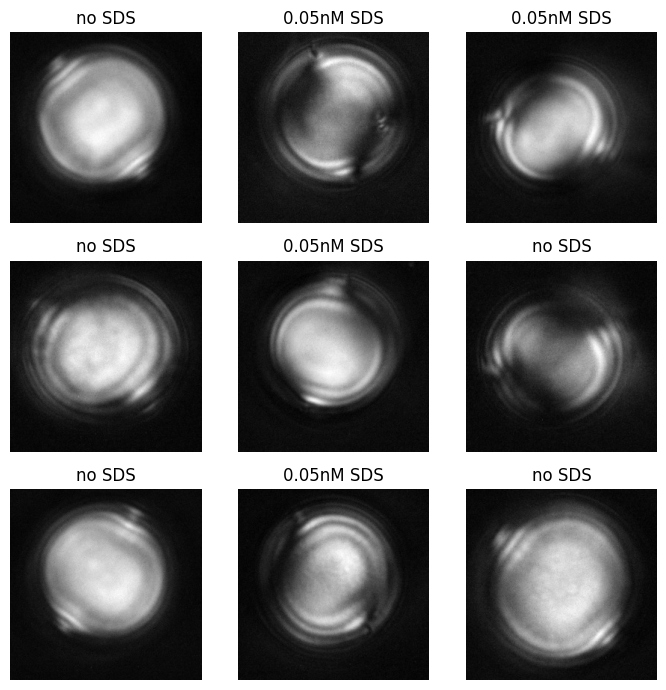

In [34]:
# Display some images from the validation set
def imshow_gray(img, title, weights=[0.2125, 0.7154, 0.0721]):
    img = np.array(img)
    weights = np.array(weights)
    img_gray = np.dot(np.transpose(img, (1, 2, 0)), weights)
    plt.imshow(img_gray, cmap="gray")
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(7,7))
val_iter = iter(valid_loader)
images, labels = next(val_iter)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow_gray(images[i], class_names[labels[i]])
plt.tight_layout()
#plt.savefig(path+'Figures/ch6_lcdroplet_sds_data_caseII_gray.eps', format='eps')
plt.show()

In [35]:
# Display activations
model.eval()
activations = []
with torch.no_grad():
    for images, _ in valid_loader:
        activations.append(model.conv1(images).detach().numpy())
activations = np.concatenate(activations, axis=0)

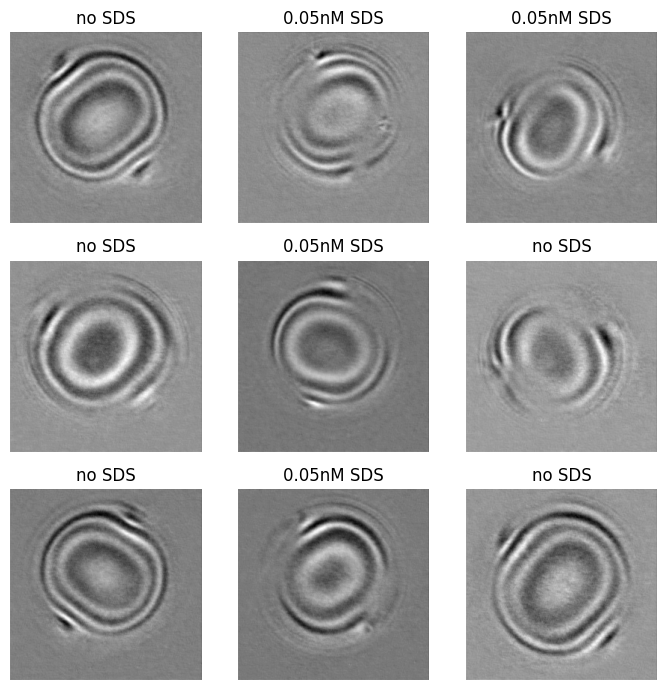

In [36]:
plt.figure(figsize=(7,7))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(activations[i, 0, :, :], cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
#plt.savefig(path+'Figures/ch6_lcdroplet_sds_activations_caseII.eps', format='eps')
plt.show()

In [37]:
filter_weight = model.conv1.weight.data.cpu().numpy()[0]
filter_weight

array([[[-0.0179923 ,  0.09792091,  0.1535118 ],
        [-0.17779696, -0.1587467 , -0.08697999],
        [-0.1413216 ,  0.0153664 , -0.03535094]],

       [[ 0.08411721, -0.1457261 ,  0.01278884],
        [-0.13791034,  0.06674211,  0.15274605],
        [-0.04853645, -0.08729694,  0.14521222]],

       [[ 0.10944436,  0.0503227 ,  0.15887214],
        [ 0.16472152,  0.07115003,  0.07664964],
        [-0.0984499 ,  0.00828014, -0.10234407]]], dtype=float32)

In [38]:
wmin = filter_weight.min()
wmax = filter_weight.max()

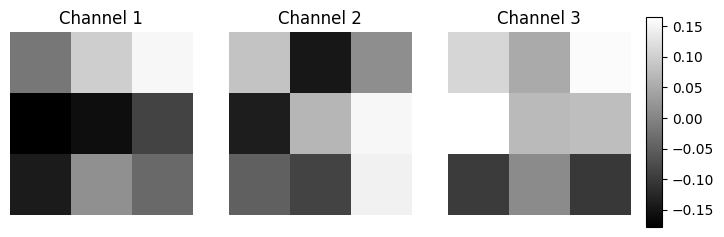

In [39]:
# Plot the weights of the filters
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for i in range(3):
    ax = axes[i]
    plot = ax.imshow(filter_weight[i, :, :], cmap='gray', vmin=wmin, vmax=wmax)
    ax.set_title(f'Channel {i+1}', fontsize=12)
    ax.axis('off')
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(plot, cax=cbar_ax)
#plt.savefig(path+'Figures/ch6_lcdroplet_sds_weights_caseII.eps', format='eps')
plt.show()